In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size': 12})
rc('mathtext',**{'default':'regular'})

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from reco.matching import get_highest_energy_fraction_simtracksters
from reco.features import longest_path_from_highest_centrality, mean_edge_length, mean_edge_energy_gap


ds_name = "CloseByTwoPion"
file_name = "new_ntuples_15101852_0.root"

data_root = "data"
raw_dir = f"/Users/ecuba/data/{ds_name}"

file_path = f"{raw_dir}/{file_name}"

tracksters = uproot.open({file_path: "ticlNtuplizer/tracksters"})
simtracksters = uproot.open({file_path: "ticlNtuplizer/simtrackstersSC"})
associations = uproot.open({file_path: "ticlNtuplizer/associations"})

In [2]:
cx = tracksters["vertices_x"].array()
cy = tracksters["vertices_y"].array()
cz = tracksters["vertices_z"].array()
ce = tracksters["vertices_energy"].array()
ci = tracksters["vertices_indexes"].array()
re = tracksters["raw_energy"].array()

sx = simtracksters["stsSC_vertices_x"].array()
sy = simtracksters["stsSC_vertices_y"].array()
sz = simtracksters["stsSC_vertices_z"].array()
se = simtracksters["stsSC_vertices_energy"].array()
si = simtracksters["stsSC_vertices_indexes"].array()

## Number of vertices and total energy

In [24]:
nvertices = []
tenergy = []
fracs = []
t_frac = []

for e in range(len(cx)):
    te = ce[e]  # get event
    reco_fr, reco_st = get_highest_energy_fraction_simtracksters(tracksters, simtracksters, associations, e)

    for tx in range(len(te)):   
        ve = te[tx]         # get trackster
        fr = reco_fr[tx]
        nvertices.append(len(ve))
        tenergy.append(sum(ve))
        fracs.append(fr)

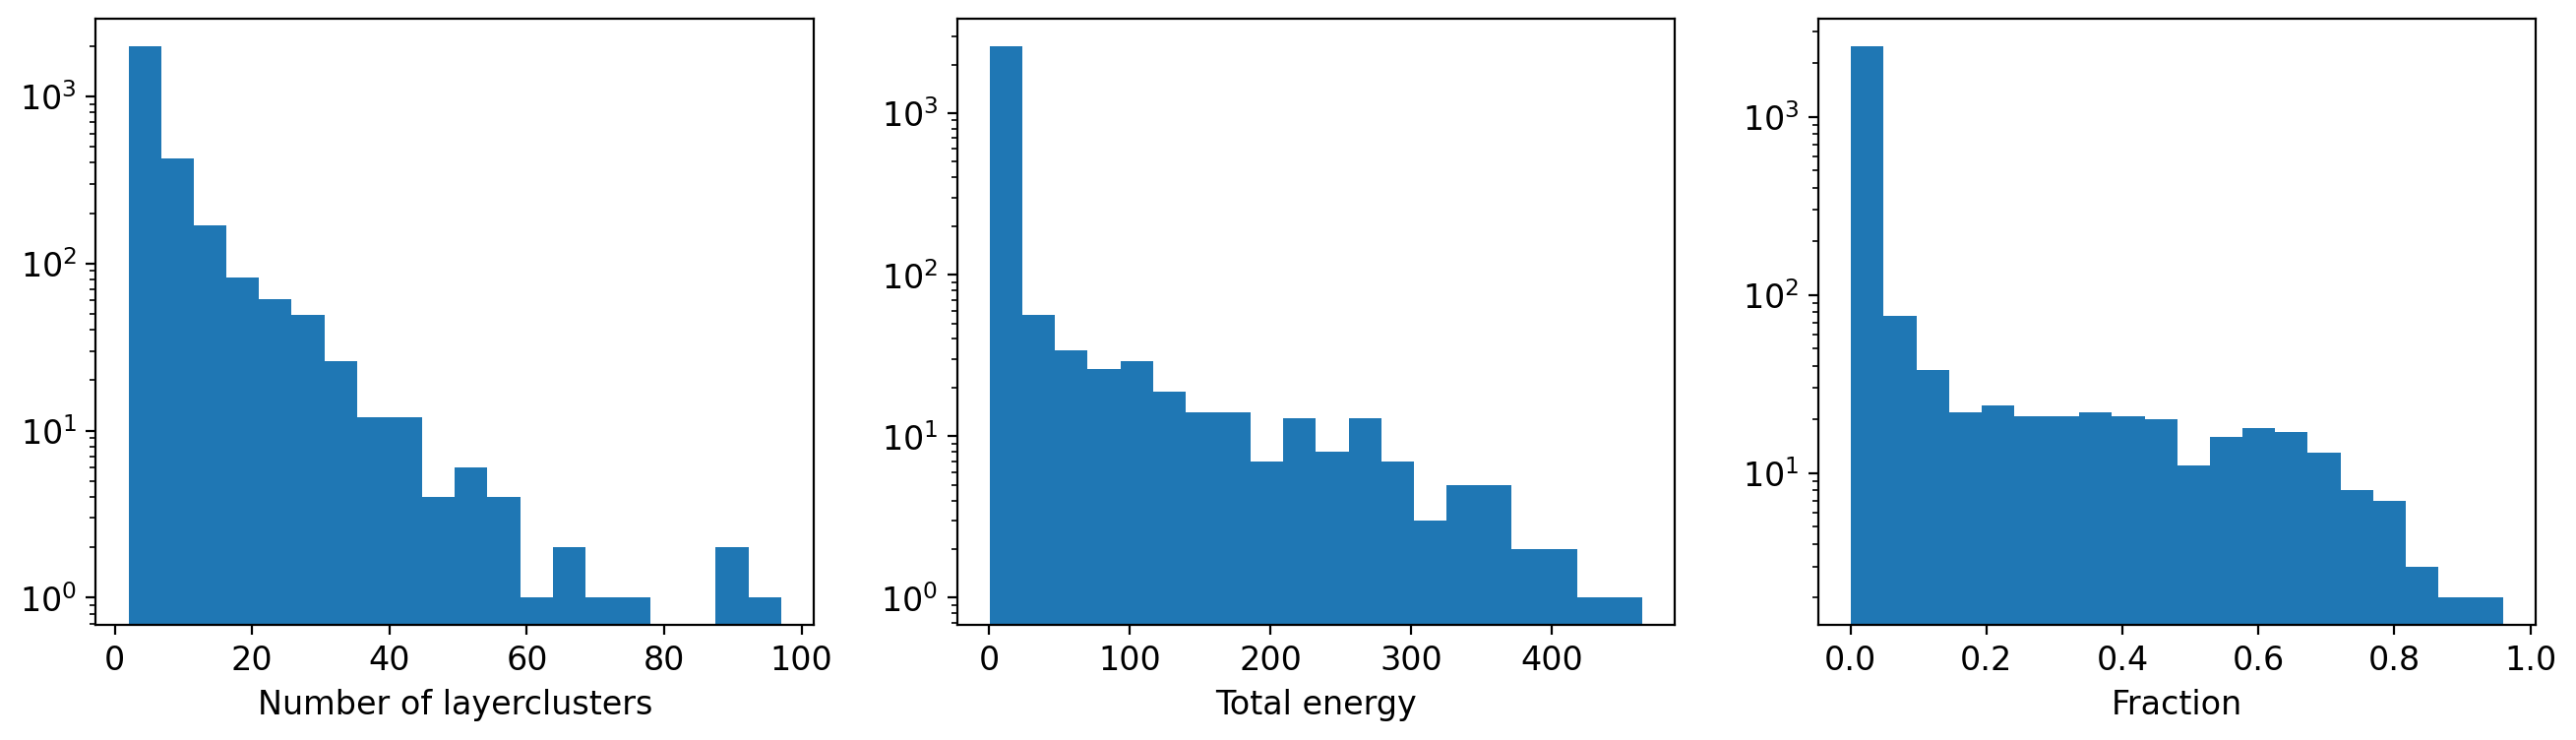

In [25]:
fig = plt.figure(figsize=(16, 4))

ax = fig.add_subplot(131)
ax.hist(nvertices, bins=20)
ax.set_yscale("log")
ax.set_xlabel("Number of layerclusters")

ax = fig.add_subplot(132)
ax.set_xlabel("Total energy")
ax.hist(tenergy, bins=20)
ax.set_yscale("log")

ax = fig.add_subplot(133)
ax.set_xlabel("Fraction")
ax.set_yscale("log")
ax.hist(fracs, bins=20)

plt.show()

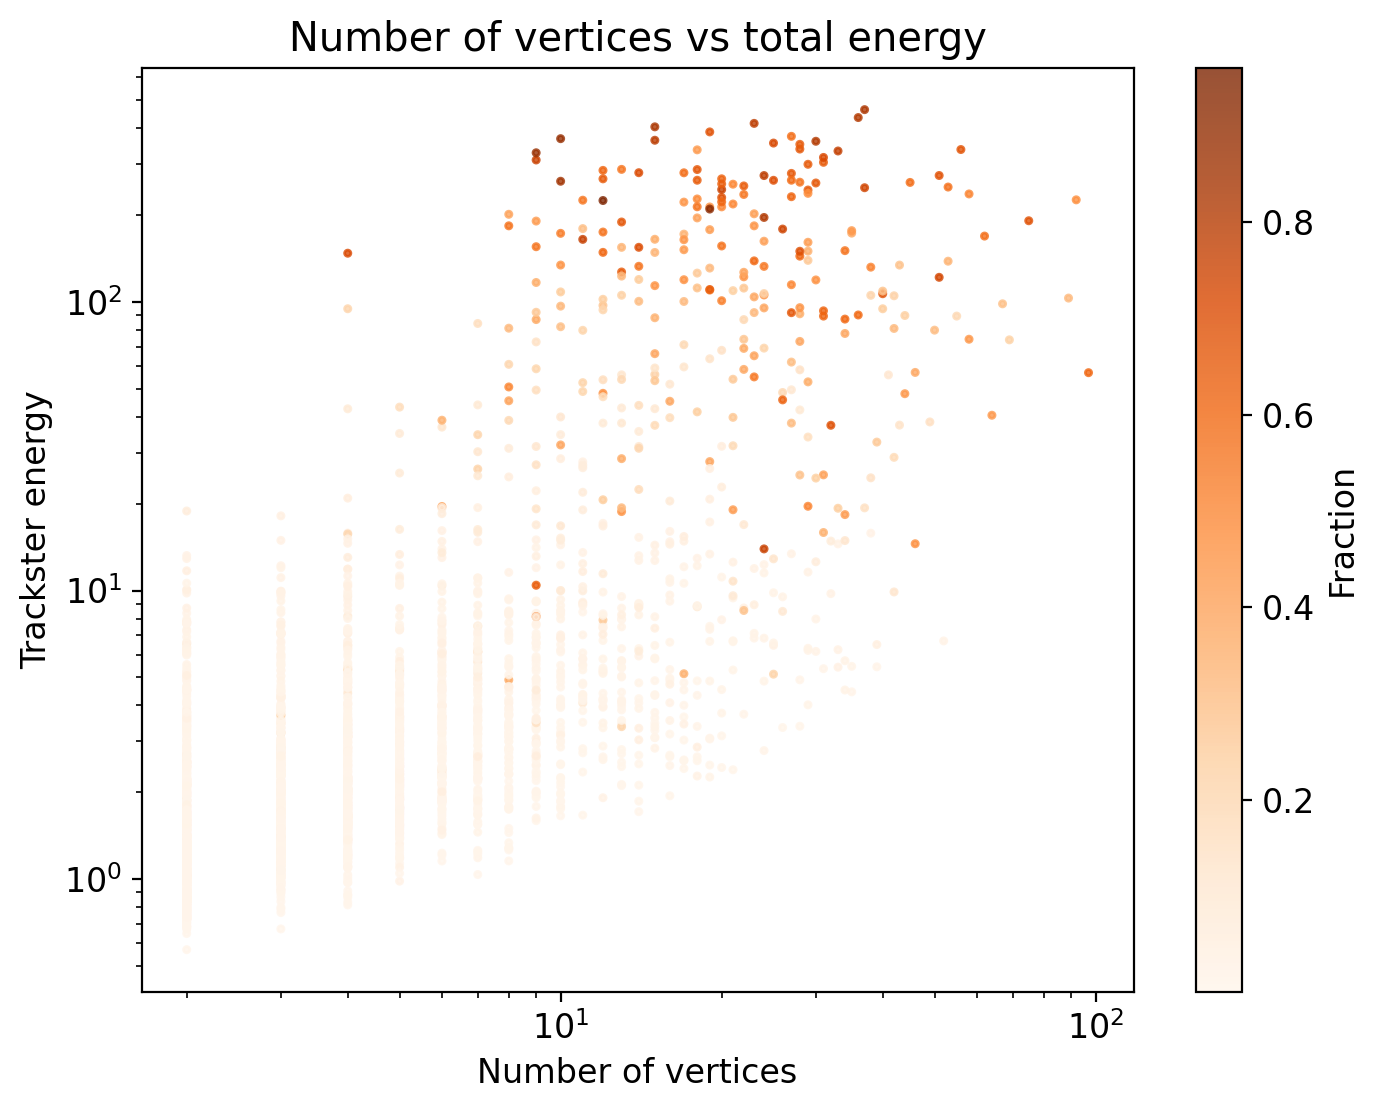

In [26]:
plt.figure(figsize=(8, 6))
plt.title("Number of vertices vs total energy")
plt.xlabel("Number of vertices")
plt.ylabel("Trackster energy")
plt.xscale("log")
plt.yscale("log")

plt.scatter(nvertices, tenergy, c=fracs, s=5, cmap="Oranges", alpha=0.8)
cbar = plt.colorbar()
cbar.set_label("Fraction")
plt.show()
# we can use the fraction as a "completeness" score

## Graph based features

In [3]:
import networkx as nx
from itertools import islice
from reco.graphs import create_graph
from reco.plotting import plot_graph_3D

In [4]:
eid = 2

np.argwhere(re[eid] > 5)

<Array [[0], [5], [11], ... [30], [39], [40]] type='10 * 1 * int64'>

['#0072B2', '#0072B2', '#0072B2', '#0072B2', '#0072B2', '#0072B2', '#0072B2', '#0072B2', '#0072B2', '#0072B2', '#0072B2', '#0072B2', '#0072B2', '#0072B2', '#0072B2', '#0072B2', '#0072B2', '#0072B2']
['#0072B2', '#0072B2', '#0072B2', '#0072B2', '#0072B2', '#0072B2', '#0072B2', '#0072B2', '#0072B2', '#0072B2', '#0072B2', '#0072B2', '#0072B2', '#0072B2', '#0072B2', '#0072B2', '#0072B2', '#0072B2']


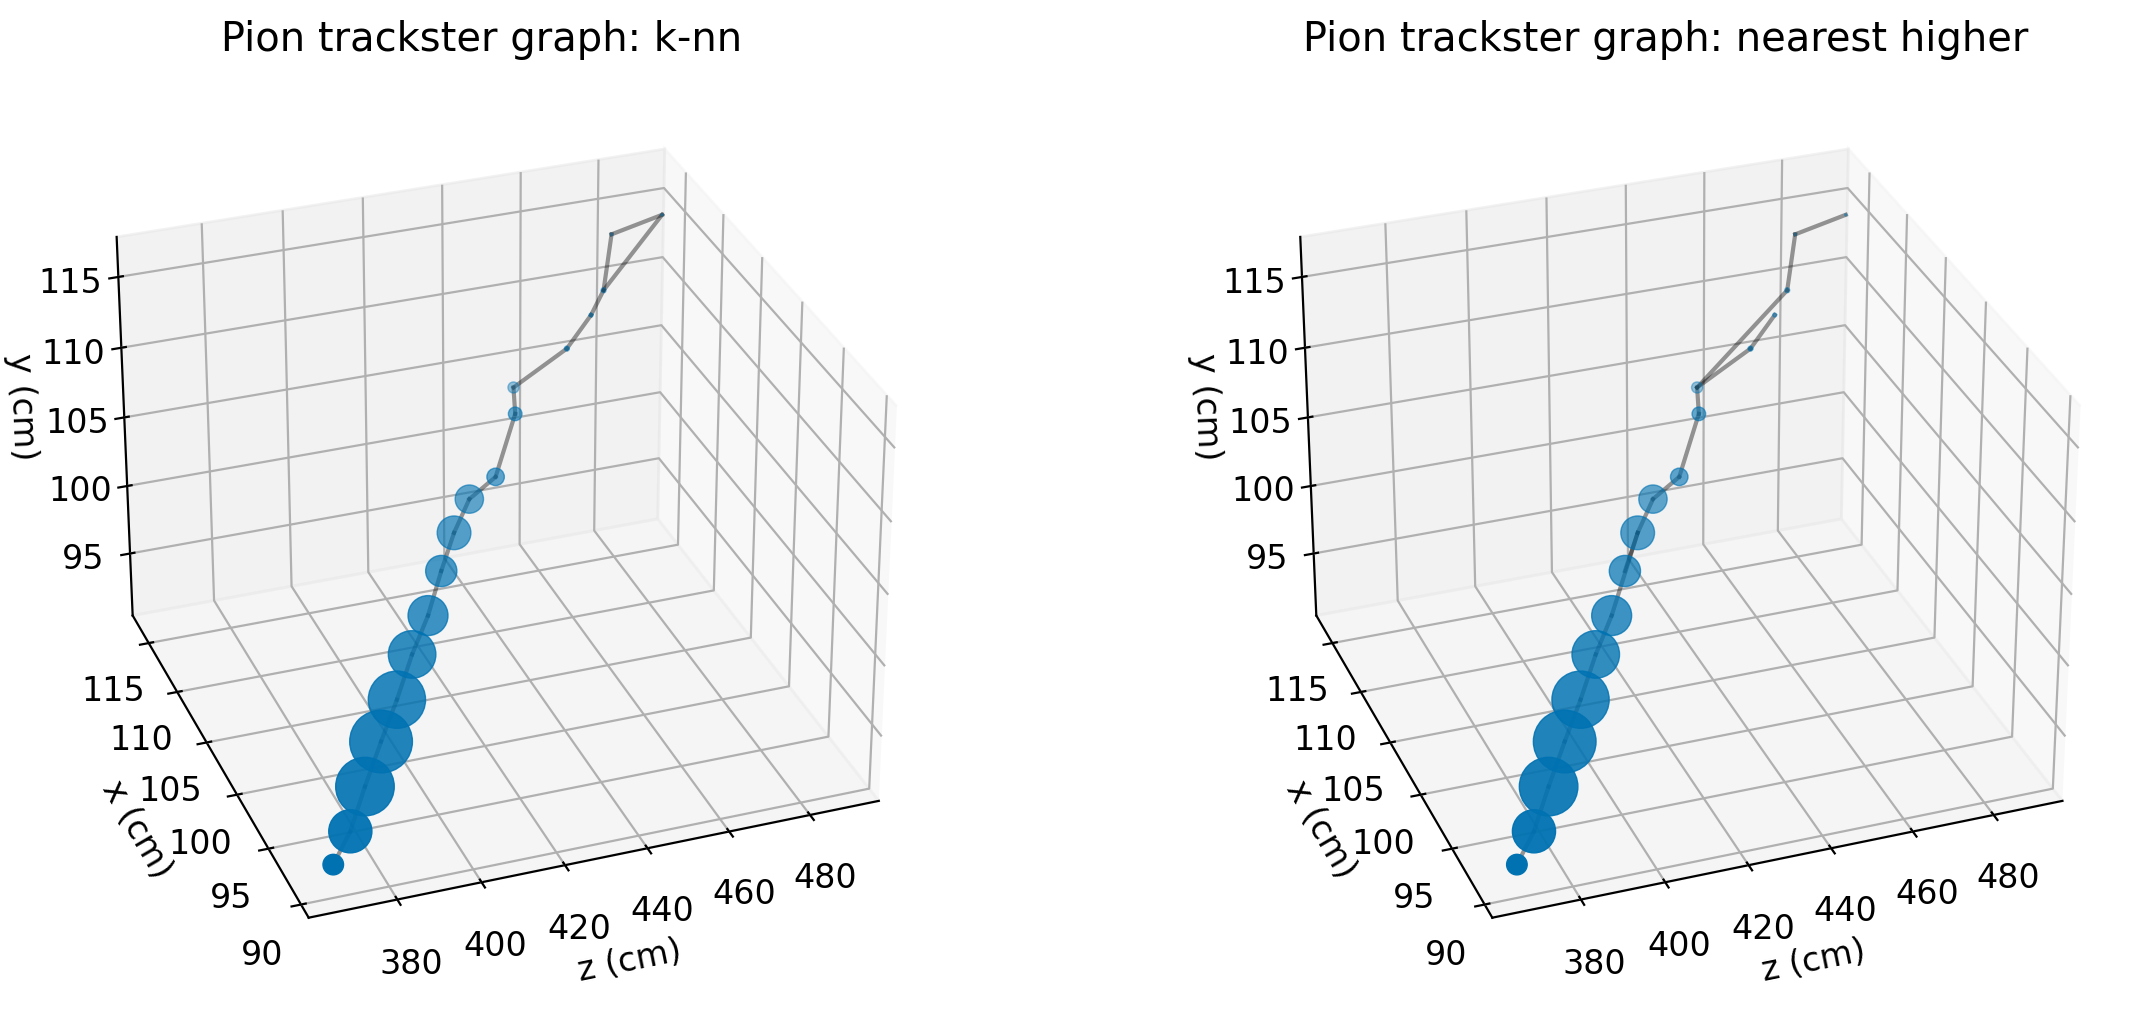

In [23]:
# 2/5 is quite nice

ntx = 5

G1 = create_graph(cx[eid][ntx], cy[eid][ntx], cz[eid][ntx], ce[eid][ntx], trk_lc_index=ci[eid][ntx], N=1, higher_e=False)
G2 = create_graph(cx[eid][ntx], cy[eid][ntx], cz[eid][ntx], ce[eid][ntx], trk_lc_index=ci[eid][ntx], N=1)

fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

ax1.set_title("Pion trackster graph: k-nn")
ax2.set_title("Pion trackster graph: nearest higher")

# nx.draw(G, with_labels=False, ax=ax1)
plot_graph_3D(G1, ax=ax1, s=10)
plot_graph_3D(G2, ax=ax2, s=10)


# should try to reuse this view across figures
ax1.view_init(elev=30, azim=-110)
ax2.view_init(elev=30, azim=-110)


# fig.savefig('export/pion-trackster-graph.png', dpi=300, bbox_inches='tight', transparent=True, pad_inches=0.1)

['#0072B2', '#0072B2', '#0072B2', '#0072B2', '#0072B2', '#0072B2', '#0072B2', '#0072B2', '#0072B2', '#0072B2', '#0072B2', '#0072B2', '#0072B2', '#0072B2', '#0072B2', '#0072B2', '#0072B2', '#0072B2']
['#D55E00', '#D55E00', '#D55E00', '#D55E00', '#D55E00', '#D55E00']


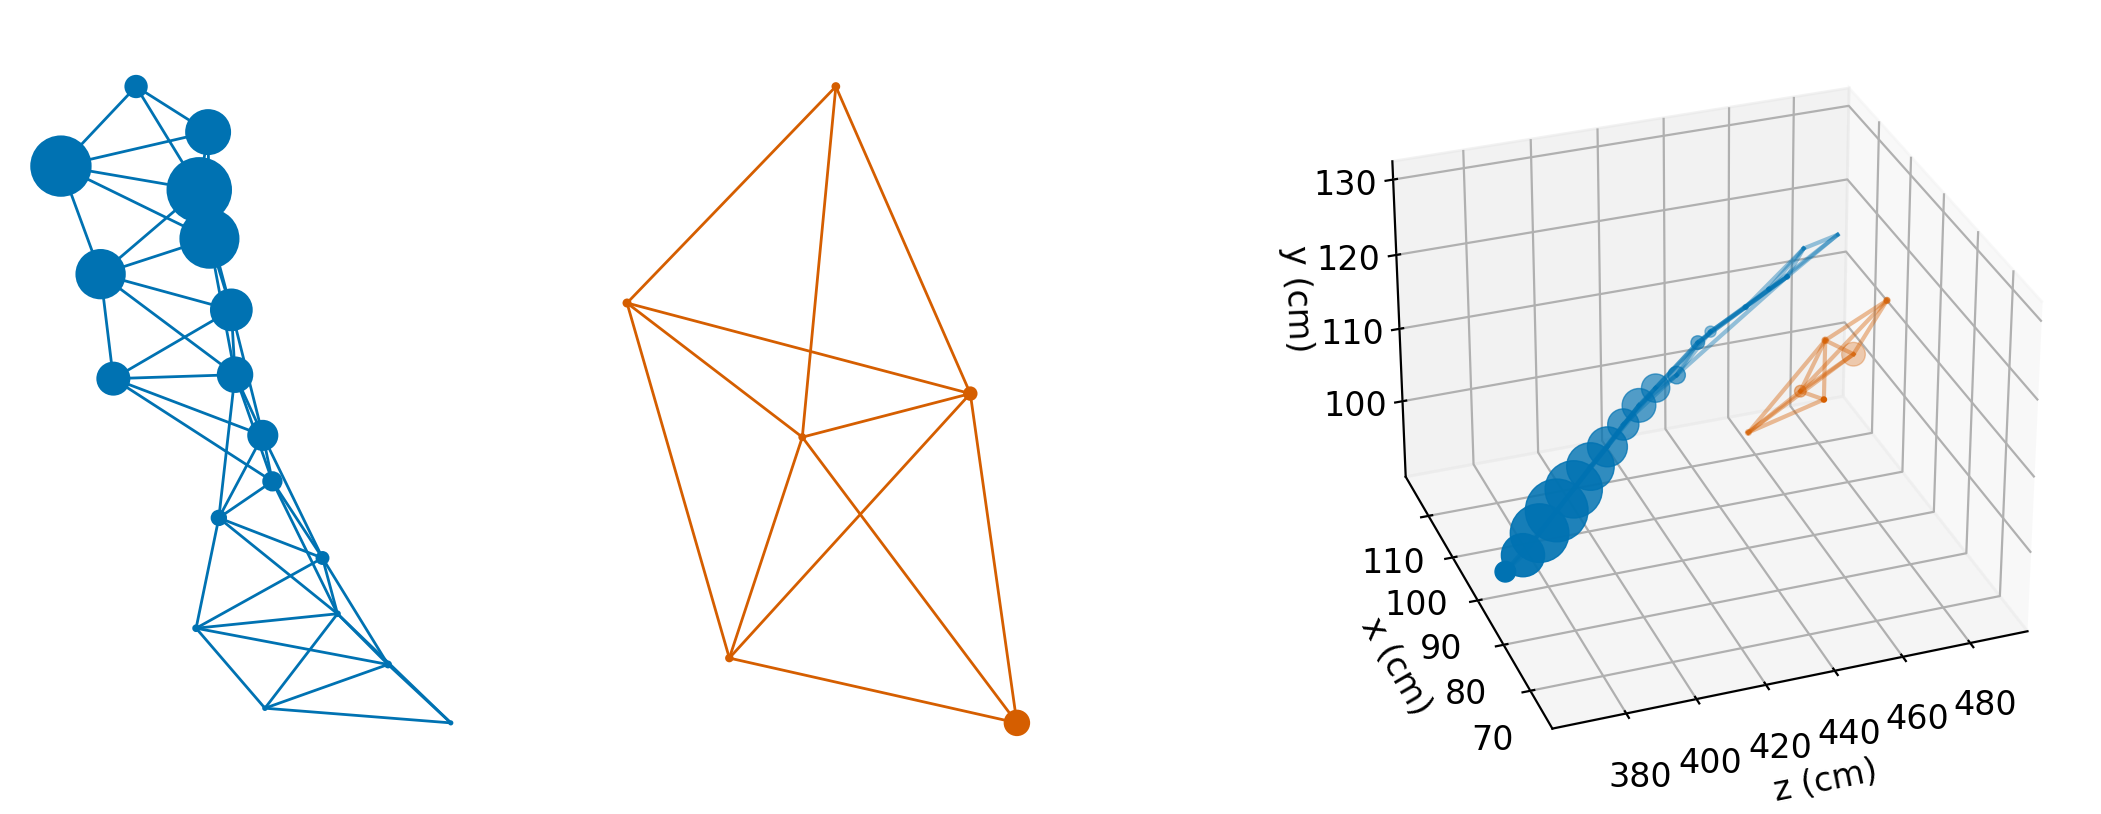

In [22]:
graphs = [(create_graph(x, y, z, e, i, N=3), e) for x, y, z, e, i in zip(cx[eid], cy[eid], cz[eid], ce[eid], ci[eid])]

fig = plt.figure(figsize=(14, 5))
ax1 = fig.add_subplot(141)
ax2 = fig.add_subplot(142)
ax3 = fig.add_subplot(122, projection='3d')

G1, e1 = graphs[5]
nx.draw(G1, with_labels=False, ax=ax1, pos=nx.spring_layout(G1), node_size=e1*10, node_color="#0072B2", edge_color="#0072B2")
nx.set_edge_attributes(G1, "#0072B2", "color")

G2, e2 = graphs[39]
nx.draw(G2, with_labels=False, ax=ax2, pos=nx.spring_layout(G2), node_size=e2*20, node_color="#D55E00", edge_color="#D55E00")

nx.set_node_attributes(G2, "#D55E00", "color")
nx.set_edge_attributes(G2, "#D55E00", "color")

plot_graph_3D(G1, ax=ax3, s=10)
plot_graph_3D(G2, ax=ax3, s=20)
ax3.view_init(elev=30, azim=-110)

fig.savefig('export/pion-trackster-structure.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()


## Graph kernels

### Bag of nodes:
- node degrees
- node centralities
- clustering coefficient

### Node based and differential features
Construct graphs by connecting to the nearest-higher.
- Using N=1 (number of nearest highers) to highlight the difference in distances.

- Average difference in energy
    - difference in energy between neighbours
    - assumes well formed tracksters are smoother

- average distance between nodes
    - same but using distance

In [35]:
avg_degree = []
avg_centrality = []
avg_clustering = []

longest_path = []
avg_ediff = []
avg_ndist = []

for eid in range(len(cx)):
    _graphs = [create_graph(x, y, z, e, i, N=2) for x, y, z, e, i in zip(cx[eid], cy[eid], cz[eid], ce[eid], ci[eid])]
    for G in _graphs:
        avg_degree.append(np.mean([d for _, d in G.degree()]))
        avg_centrality.append(np.mean(list(nx.degree_centrality(G).values())))
        avg_clustering.append(nx.average_clustering(G))
        longest_path.append(longest_path_from_highest_centrality(G))
        avg_ndist.append(mean_edge_length(G))
        avg_ediff.append(mean_edge_energy_gap(G))

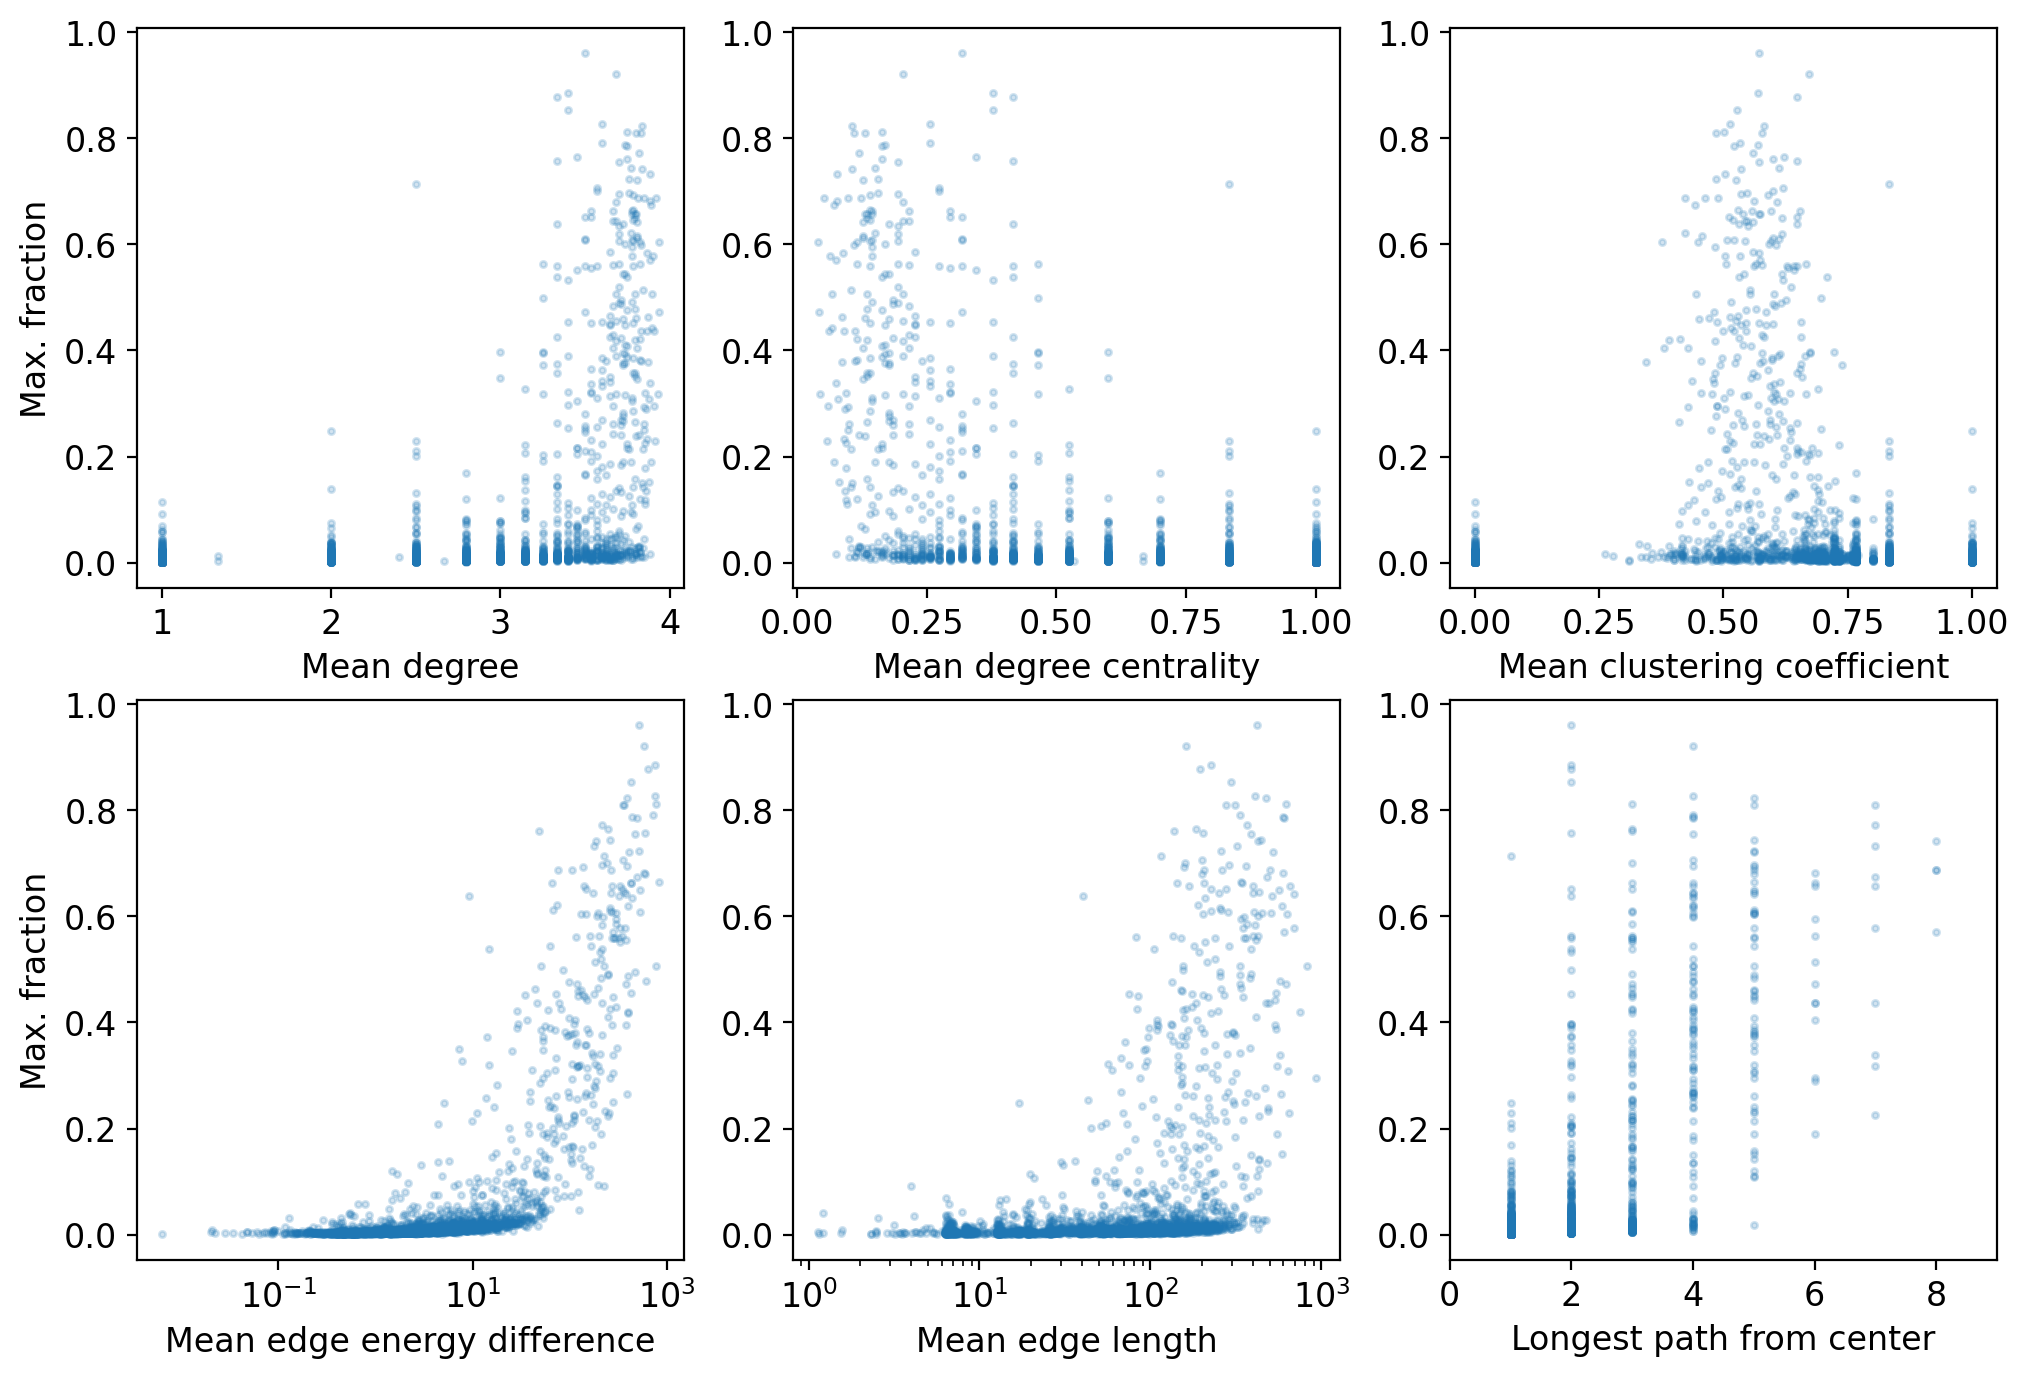

In [58]:
fig = plt.figure(figsize=(12, 8))

ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)

ax1.set_xlabel("Mean degree")
ax1.set_ylabel("Max. fraction")
ax1.scatter(avg_degree, fracs, alpha=0.2, s=5)

ax2.set_xlabel("Mean degree centrality")
ax2.scatter(avg_centrality, fracs, alpha=0.2, s=5)

ax3.set_xlabel("Mean clustering coefficient")
ax3.scatter(avg_clustering, fracs, alpha=0.2, s=5)

ax4.set_ylabel("Max. fraction")
ax4.scatter(avg_ediff, fracs, alpha=0.2, s=5)
ax4.set_xscale("log")
ax4.set_xlabel("Mean edge energy difference")

ax5.set_xlabel("Mean edge length")
ax5.scatter(avg_ndist, fracs, alpha=0.2, s=5)
ax5.set_xscale("log")

ax6.set_xlabel("Longest path from center")
ax6.scatter(longest_path, fracs, alpha=0.2, s=5)
ax6.set_xlim(0, 9)


fig.savefig('export/graph-features.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

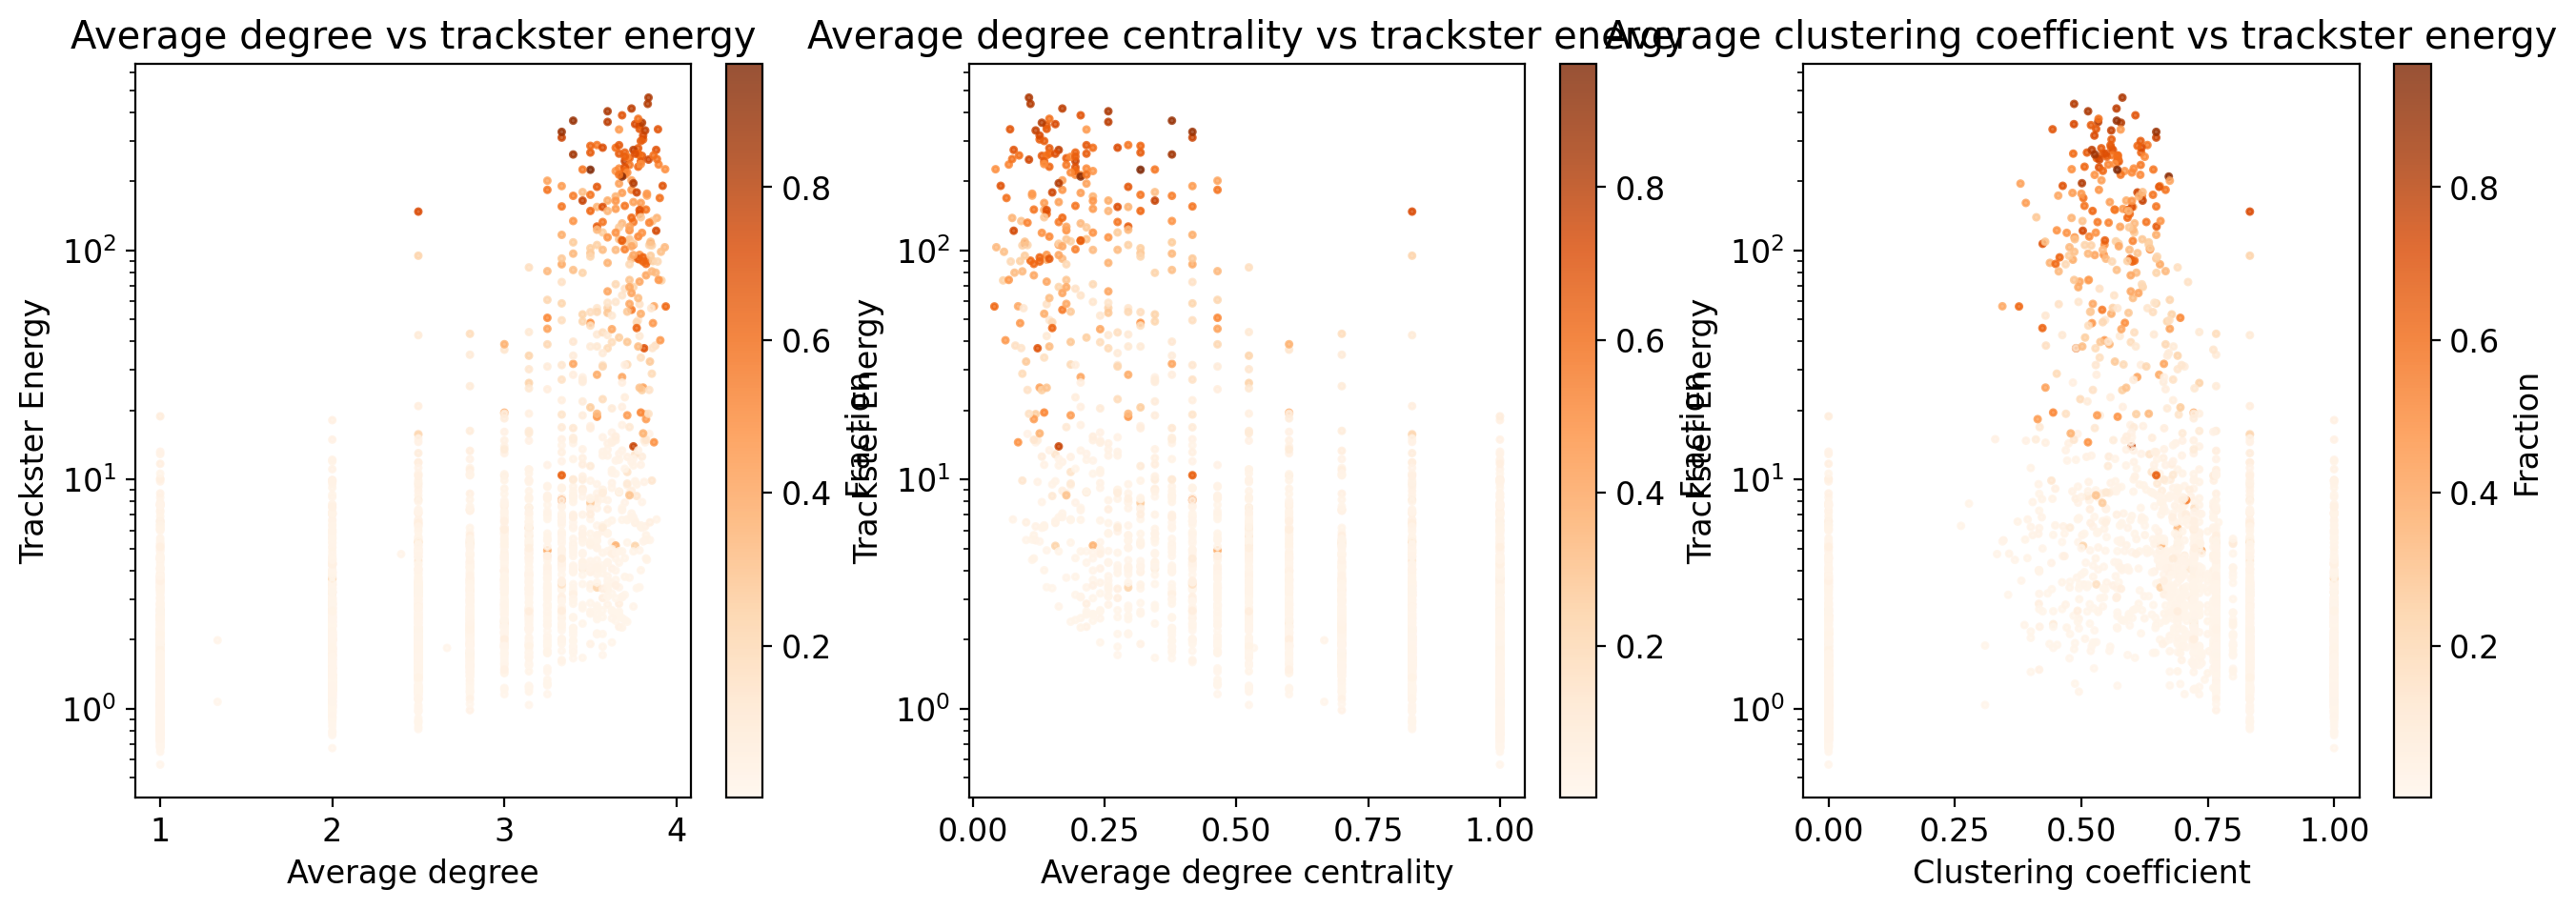

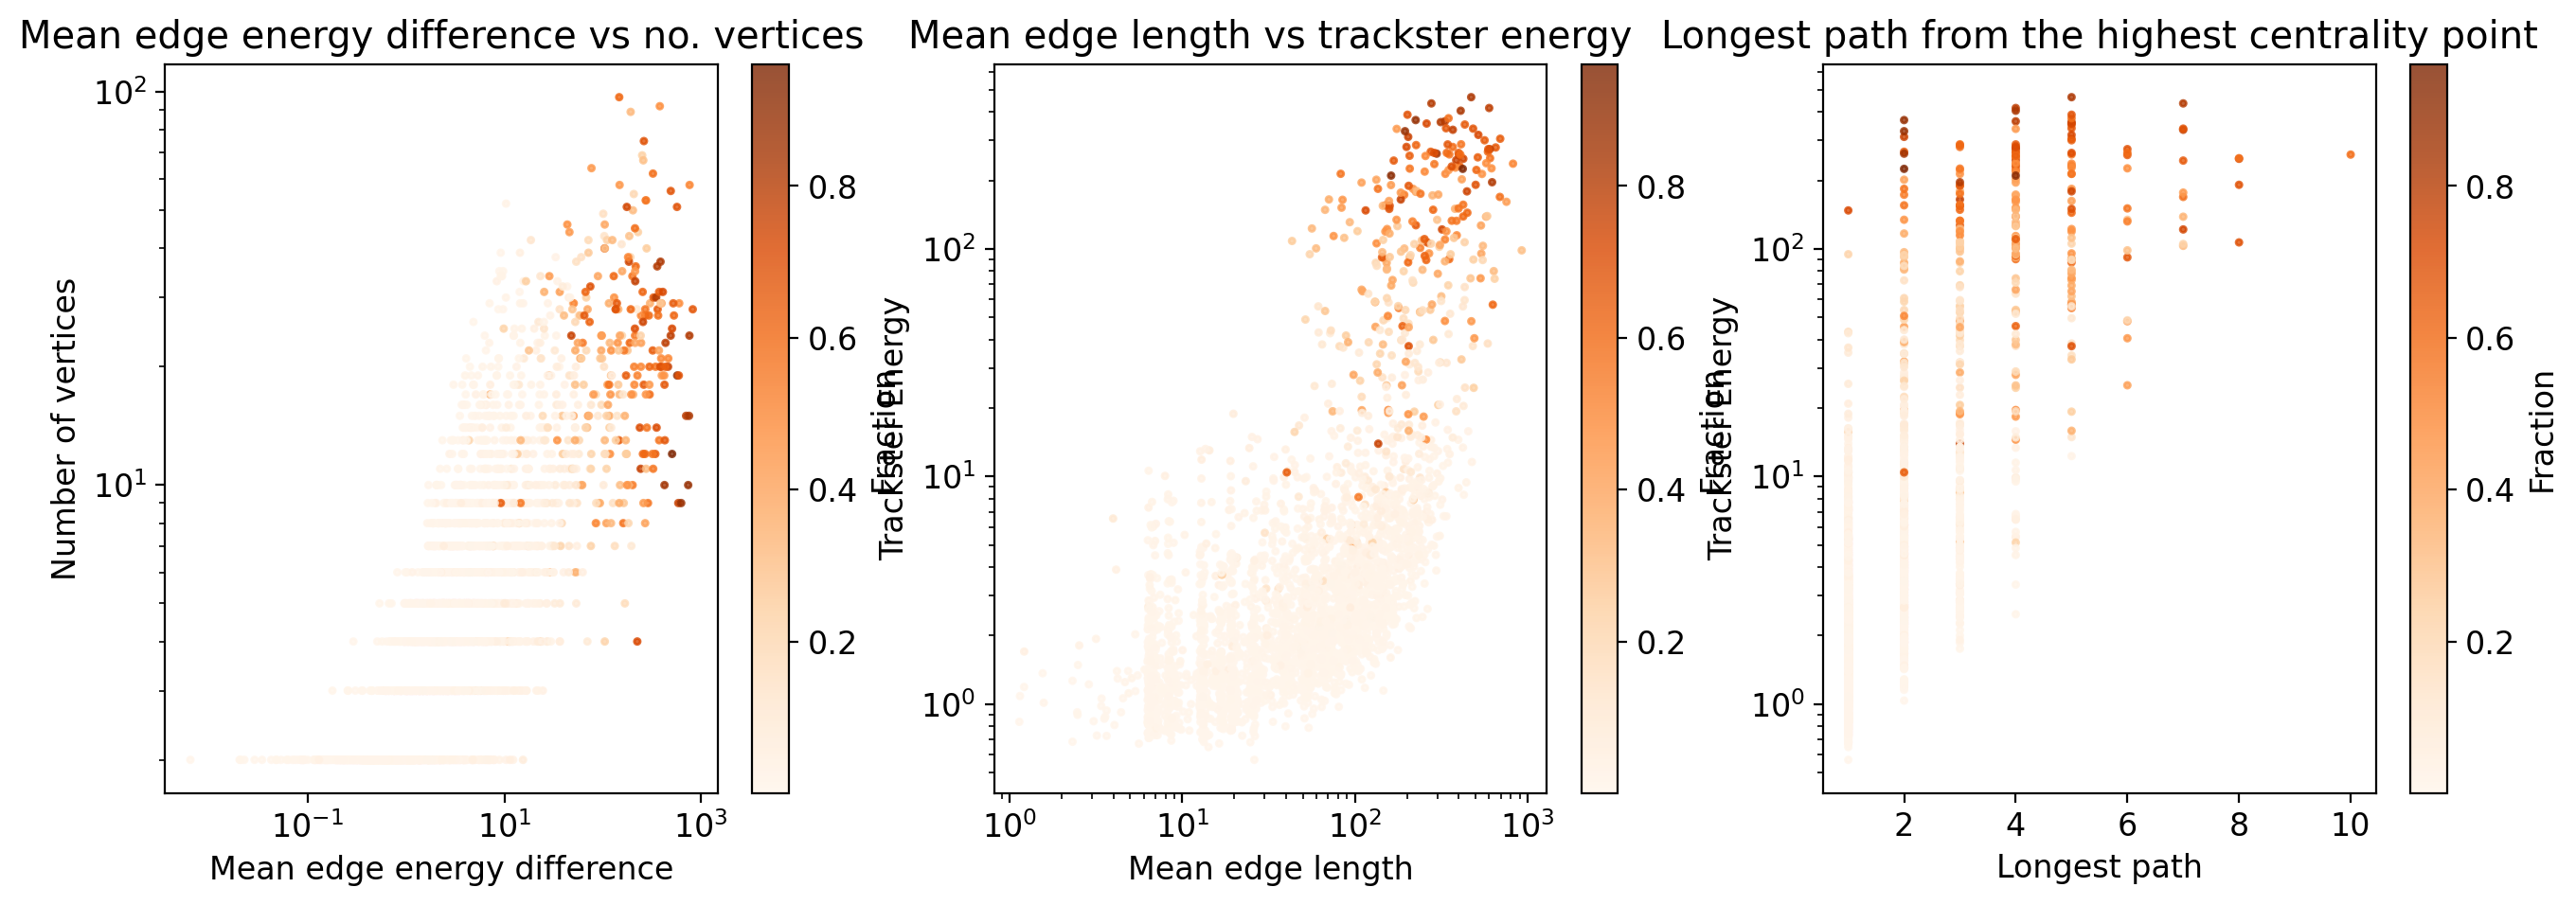

In [34]:

fig = plt.figure(figsize=(16, 5))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title("Average degree vs trackster energy")
ax1.set_xlabel("Average degree")
ax1.set_ylabel("Trackster Energy")
ax1.set_yscale("log")

sc1 = ax1.scatter(avg_degree, tenergy, c=fracs, s=5, cmap="Oranges", alpha=0.8)
cbar1 = fig.colorbar(sc1, ax=ax1)
cbar1.set_label("Fraction")


ax2.set_title("Average degree centrality vs trackster energy")
ax2.set_xlabel("Average degree centrality")
ax2.set_ylabel("Trackster Energy")
ax2.set_yscale("log")

sc2 = ax2.scatter(avg_centrality, tenergy, c=fracs, s=5, cmap="Oranges", alpha=0.8)
cbar2 = fig.colorbar(sc2, ax=ax2)
cbar2.set_label("Fraction")

ax3.set_title("Average clustering coefficient vs trackster energy")
ax3.set_xlabel("Clustering coefficient")
ax3.set_ylabel("Trackster Energy")
ax3.set_yscale("log")

sc3 = ax3.scatter(avg_clustering, tenergy, c=fracs, s=5, cmap="Oranges", alpha=0.8)
cbar3 = fig.colorbar(sc3, ax=ax3)
cbar3.set_label("Fraction")

plt.show()


fig = plt.figure(figsize=(16, 5))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title("Mean edge energy difference vs no. vertices")
ax1.set_xlabel("Mean edge energy difference")
ax1.set_ylabel("Number of vertices")
ax1.set_xscale("log")
ax1.set_yscale("log")

sc1 = ax1.scatter(avg_ediff, nvertices, c=fracs, s=5, cmap="Oranges", alpha=0.8)
cbar1 = fig.colorbar(sc1, ax=ax1)
cbar1.set_label("Fraction")

ax2.set_title("Mean edge length vs trackster energy")
ax2.set_xlabel("Mean edge length")
ax2.set_ylabel("Trackster Energy")
ax2.set_xscale("log")
ax2.set_yscale("log")

sc2 = ax2.scatter(avg_ndist, tenergy, c=fracs, s=5, cmap="Oranges", alpha=0.8)
cbar2 = fig.colorbar(sc2, ax=ax2)
cbar2.set_label("Fraction")

ax3.set_title("Longest path from the highest centrality point")
ax3.set_xlabel("Longest path")
ax3.set_ylabel("Trackster Energy")
ax3.set_yscale("log")

sc3 = ax3.scatter(longest_path, tenergy, c=fracs, s=5, cmap="Oranges", alpha=0.8)
cbar3 = fig.colorbar(sc3, ax=ax3)
cbar3.set_label("Fraction")

plt.show()

## Combine the features with PCA

In [90]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()

X = np.array((nvertices, tenergy, longest_path, avg_ediff, avg_ndist, avg_centrality, avg_degree)).T
Xs = scaler.fit_transform(X)

pca = PCA(n_components=2).fit(Xs)
data = pca.transform(Xs)

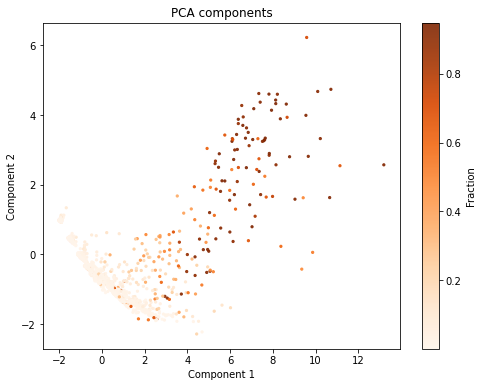

In [91]:
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)

ax1.set_title("PCA components")
ax1.set_xlabel("Component 1")
ax1.set_ylabel("Component 2")

sc1 = ax1.scatter(data[:,0], data[:,1], c=fracs, s=5, cmap="Oranges", alpha=0.9)
cbar1 = fig.colorbar(sc1, ax=ax1)
cbar1.set_label("Fraction")

plt.show()

## Differential features

Features for comparing two different graphs

## Feature decorrelation

Figure out which features make sense